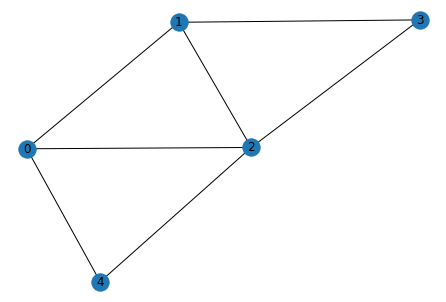

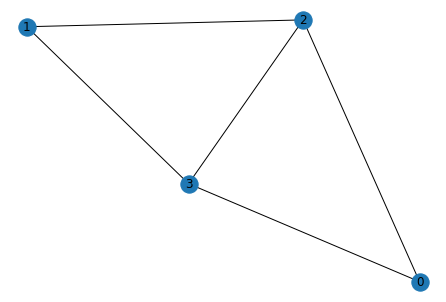

st_d5_th0.01_lr0.01
0.747401
0.21079193
0.0061965766
0.0020486938


In [1]:
import tensorflow as tf
import numpy as np
import gnn.gnn_utils as gnn_utils
from gnn.GNN import GNN as GraphNetwork

import networkx as nx
import scipy as sp

import matplotlib.pyplot as plt

##### GPU & stuff config
import os

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

############# data creation ################

# GRAPH #1

# List of edges in the first graph - last column is the id of the graph to which the arc belongs
e = [[0, 1, 0], [0,2, 0], [0, 4, 0], [1, 2, 0], [1, 3, 0], [2, 3, 0], [2, 4, 0]]
# undirected graph, adding other direction
e.extend([[i, j, num] for j, i, num in e])
#reorder
e = sorted(e)
E = np.asarray(e)


#number of nodes
edges = 5
# creating node features - simply one-hot values
N = np.eye(edges, dtype=np.float32)

# adding column thta represent the id of the graph to which the node belongs
N = np.concatenate((N, np.zeros((edges,1), dtype=np.float32)),  axis=1 )


# visualization graph
def plot_graph(E, N):
    g = nx.Graph()
    g.add_nodes_from(range(N.shape[0]))
    g.add_edges_from(E[:, :2])
    nx.draw(g, cmap=plt.get_cmap('Set1'), with_labels=True)
    plt.show()


plot_graph(E,N)



# GRAPH #2

# List of edges in the second graph - last column graph-id
e1 = [[0, 2, 1], [0,3,1], [1, 2,1], [1,3,1], [2,3,1]]
# undirected graph, adding other direction
e1.extend([[i, j, num] for j, i, num in e1])
# reindexing node ids based on the dimension of previous graph (using unique ids)
e2 = [[a + N.shape[0], b + N.shape[0], num] for a, b, num in e1]
#reorder
e2 = sorted(e2)


edges_2 = 4


# Plot second graph

E1 = np.asarray(e1)

N1 = np.eye(edges_2,  dtype=np.float32)
N1 = np.concatenate((N1, np.zeros((edges_2,1), dtype=np.float32)),  axis=1 )

plot_graph(E1,N1)

E = np.concatenate((E, np.asarray(e2)), axis=0)

N_tot = np.eye(edges + edges_2,  dtype=np.float32)
N_tot = np.concatenate((N_tot, np.zeros((edges + edges_2,1), dtype=np.float32)),  axis=1 )


# Create Input to GNN

inp, arcnode, nodegraph = gnn_utils.from_EN_to_GNN(E, N_tot)
labels = np.random.randint(2, size=(N_tot.shape[0]))


labels = np.eye(max(labels)+1, dtype=np.int32)[labels]  # one-hot encoding of labels


################################################################################################
################################################################################################
################################################################################################
################################################################################################


EPSILON = 0.00000001

@tf.function()
def loss(target,output):
    target = tf.cast(target,tf.float32)
    output = tf.maximum(output, EPSILON, name="Avoiding_explosions")  # to avoid explosions
    xent = -tf.reduce_sum(target * tf.math.log(output), 1)
    lo = tf.reduce_mean(xent)
    return lo

@tf.function()
def metric(output, target):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(target, 1))
    metric = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return metric

# set input and output dim, the maximum number of iterations, the number of epochs and the optimizer
threshold = 0.01
learning_rate = 0.01
state_dim = 5
input_dim = inp.shape[1]
output_dim = labels.shape[1]
max_it = 50
num_epoch = 100

def create_model():

    comp_inp = tf.keras.Input(shape=(input_dim), name="input")
    
    gnn_layer = GraphNetwork(input_dim, state_dim, output_dim,
                             hidden_state_dim = 15, hidden_output_dim = 10,
                             ArcNode=arcnode,NodeGraph=None,threshold=threshold)
    
    output = gnn_layer(comp_inp)
    
    model = tf.keras.Model(comp_inp, output)

    return model,gnn_layer


tf.keras.backend.clear_session()
model,GNNLayer = create_model()

# initialize GNN
param = "st_d" + str(state_dim) + "_th" + str(threshold) + "_lr" + str(learning_rate)
print(param)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
for _ in range(num_epoch):

    with tf.GradientTape() as tape:
        
        out = model(inp,training=True)

        loss_value = loss(labels,out)

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        if _ % 30 == 0:
            print(loss_value.numpy())

In [ ]:
GNNLayer.predict_node(inp,arcnode)